<a href="https://colab.research.google.com/github/AlexandruPetrus/Portfolio/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation du jeu de données et des librairies

In [ ]:
# import librairies
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler

import sqlite3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# initiation de la connexion
path = '/content/drive/MyDrive/FPA_FOD_20170508.sqlite'
con = sqlite3.connect(path)

In [ ]:
# recuperation de la table fire dans le df fire avec sélection des variables utiles
fires = pd.read_sql_query('SELECT FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE FROM Fires', con)

In [ ]:
# affichage
display(fires)

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
0,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,CA
1,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,CA
2,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,CA
3,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,CA
4,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,2015,2457291.5,269,1726,13.0,Missing/Undefined,2457291.5,269.0,1843,0.01,A,40.481637,-122.389375,CA
1880461,2015,2457300.5,278,0126,9.0,Miscellaneous,NaN,NaN,None,0.20,A,37.617619,-120.938570,CA
1880462,2015,2457144.5,122,2052,13.0,Missing/Undefined,NaN,NaN,None,0.10,A,37.617619,-120.938570,CA
1880463,2015,2457309.5,287,2309,13.0,Missing/Undefined,NaN,NaN,None,2.00,B,37.672235,-120.898356,CA


In [ ]:
# verification
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 14 columns):
 #   Column            Dtype  
---  ------            -----  
 0   FIRE_YEAR         int64  
 1   DISCOVERY_DATE    float64
 2   DISCOVERY_DOY     int64  
 3   DISCOVERY_TIME    object 
 4   STAT_CAUSE_CODE   float64
 5   STAT_CAUSE_DESCR  object 
 6   CONT_DATE         float64
 7   CONT_DOY          float64
 8   CONT_TIME         object 
 9   FIRE_SIZE         float64
 10  FIRE_SIZE_CLASS   object 
 11  LATITUDE          float64
 12  LONGITUDE         float64
 13  STATE             object 
dtypes: float64(7), int64(2), object(5)
memory usage: 200.9+ MB


In [ ]:
# mise du nom des variables en minuscule
fires.columns = [col.lower() for col in fires.columns]
# verif
fires.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state
0,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,CA
1,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,CA
2,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,CA
3,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,CA
4,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,CA


In [ ]:
# sauvegarde pour ne pas reprendre l'importation
fires_save = fires.copy()

# Premières informations

In [ ]:
# Présence de doublon
print('le nombre de doublon est de : ',fires.duplicated().sum())

le nombre de doublon est de :  3535


In [ ]:
print('taille du df avant suppression des doublons :',fires.shape)
# Suppression des doublons
fires = fires.drop_duplicates(keep='first').reset_index(drop=True)
# info
print('taille du df après suppression des doublons :', fires.shape)

taille du df avant suppression des doublons : (1880465, 14)
taille du df après suppression des doublons : (1876930, 14)


In [ ]:
# fonction summary retournant un resume du df
def summary(df):
    """
    Argument : un dataframe

    Fonction retournant un dataframe contenant :
        Le nom de la variable (en index)
        Le type informatique de la variable
        Le % de valeurs manquantes
        Le nombre de valeurs uniques
        Les valeurs uniques lorsque le nombre de catégories le permet
        La valeur moyenne lorsque la variable est de type quantitatif
        La valeur médiane lorsque la variable est de type quantitatif
        La valeur la plus fréquente lorsque la variable est de type qualitatif
        Une alerte si quelque chose est à regarder en particulier sur les na et les modalites
    """
    # creation des fonctions nécessaires
    # recuperation des valeurs unique si 5 val max
    def rcv_val_unique(col):
        if col.nunique() < 6 :
            return col.unique()
        else:
            return 'trop de valeurs'

    # recuperation de la moyenne des valeurs numériques
    def rcv_val_moy(col):
        if col.dtypes == 'int' or col.dtypes == 'float':
            return col.mean()

    # recuperation de la médiane des valeurs numériques
    def rcv_val_med(col):
        if col.dtypes == 'int' or col.dtypes == 'float':
            return col.median()

    # recuperation du mode des valeurs categorielles
    def rcv_val_mod(col):
        if col.dtypes == 'O' :
            return col.mode()[0]

    # fonction d'alerte
    def alerte_seuil(col, seuil_na = 0.25, seuil_mod = 0.80): # mise de valeurs par défaut
        if (col.isna().sum() / len(df)) > seuil_na:
            return 'trop de na'
        elif col.value_counts(normalize = 1).values[0] > seuil_mod:
            return 'desequilibre modalités'
        else:
            return 'RAS'


    # initialisation du df contenant les informations
    df_info = pd.DataFrame(index = df.columns,
                           columns = ['type_var', 'tx_na', 'nb_val_unique', 'val_unique','val_moy', 'val_med', 'mode', 'alert'])

    # affectation des valeurs
    df_info.loc[:,'type_var'] = df.dtypes.values # recup des types
    df_info.loc[:,'tx_na'] = (df.isna().sum() / len(df))*100 # calcul tx na
    df_info.loc[:,'nb_val_unique'] = df.nunique().values # recup nb de val unique
    df_info.loc[:,'val_unique'] = df.apply(rcv_val_unique) # recup des val unique
    df_info.loc[:,'val_moy'] = df.apply(rcv_val_moy) # recup de la moyenne
    df_info.loc[:,'val_med'] = df.apply(rcv_val_med) # recup de la mediane
    df_info.loc[:,'mode'] = df.apply(rcv_val_mod) # recup du mode
    df_info.loc[:,'alert'] = df.apply(alerte_seuil) # mise d'un message d'alerte

    return df_info

In [ ]:
# premieres informations
summary(fires)

<ipython-input-11-c5b5b4647416>:56: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_info.loc[:,'tx_na'] = (df.isna().sum() / len(df))*100 # calcul tx na
<ipython-input-11-c5b5b4647416>:57: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_info.loc[:,'nb_val_unique'] = df.nunique().values # recup nb de val unique
<ipython-input-11-c5b5b4647416>:59: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.colum

,type_var,tx_na,nb_val_unique,val_unique,val_moy,val_med,mode,alert
fire_year,int64,0.000000,24,trop de valeurs,2.003714e+03,2.004000e+03,None,RAS
discovery_date,float64,0.000000,8766,trop de valeurs,2.453065e+06,2.453180e+06,None,RAS
discovery_doy,int64,0.000000,366,trop de valeurs,1.647231e+02,1.640000e+02,None,RAS
discovery_time,object,46.905106,1440,trop de valeurs,NaN,NaN,1400,trop de na
stat_cause_code,float64,0.000000,13,trop de valeurs,5.977565e+00,5.000000e+00,None,RAS
stat_cause_descr,object,0.000000,13,trop de valeurs,NaN,NaN,Debris Burning,RAS
cont_date,float64,47.383067,8760,trop de valeurs,2.453239e+06,2.453468e+06,None,trop de na
cont_doy,float64,47.383067,366,trop de valeurs,1.726616e+02,1.810000e+02,None,trop de na
cont_time,object,51.671133,1441,trop de valeurs,NaN,NaN,1800,trop de na
fire_size,float64,0.000000,13637,trop de valeurs,7.465836e+01,1.000000e+00,None,RAS


# EXPLORATION

In [ ]:
# sauvegarde avant modification
fires_info = fires.copy()

NameError: name 'fires' is not defined

## Modification des formats

In [ ]:
# discovery_date / cont_date: à mettre au format date
# dates calées au calendrier julian
fires['discovery_date'] = pd.to_datetime(fires['discovery_date'], unit='D', origin='julian')
fires['cont_date'] = pd.to_datetime(fires['cont_date'], unit='D', origin='julian')

# 'stat_cause_code' : mise au format int
fires['stat_cause_code'] = fires['stat_cause_code'].astype(int)

# verification
display(fires.head())
fires.info()

## Contrôles des données

### *Controle geographique*
1.   Existance des états
2.   Latitute / Longitude par état



In [ ]:
# fonction d'alerte pour un ecart trop important entre deux valeurs en prenant en compte un seuil de test
def test_delta(val_r, val_t, seuil=0.1):
  """
  fonction pour calculer l'écart entre 2 valeurs et accépter ou non cet écart en fonction du seuil donné
  ou celui par défaut de 10%

  Arguments :
  val_r : valeur de référence
  val_t : valeur testée
  seuil : 10% par défaut

  Retoune :
  1 si l'écart est supérieur au seuil
  0 si l'écart est inférieur ou égal au seuil
  """
  if abs((val_t - val_r)/val_r) > seuil:
    return 1
  else:
    return 0

# liste contenant tous les états des USA
# prise en compte de PUERTO-RICO (PR)
USA_state = ['AL', 'AK', 'AZ', 'AR', 'CA', 'NC', 'SC', 'CO', 'CT', 'ND', 'SD', 'DE', 'FL', 'GA', 'HI',
             'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT' ,
             'NE', 'NV', 'NH', 'NJ', 'NY', 'NM', 'OH', 'OK', 'OR', 'PA', 'RI', 'TN', 'TX', 'UT', 'VT',
             'VA', 'WV', 'WA', 'WI', 'WY', 'PR']

# creation d'un dictionnaire avec les latitudes et les longitudes min et max par state
dico_lat_long = {"AK": (52.5964, 71.5232, -169.9146, -129.993),
                 "AL": (30.1463, 35.0041, -88.4743, -84.8927),
                 "AR": (33.0075, 36.4997,-94.6198, -89.6594),
                 "AZ": (31.3325, 37.0004, -114.8126, -109.0475),
                 "CA": (32.5121, 42.0126, -124.6509, -114.1315),
                 "CO": (36.9949, 41.0006, -109.0489, -102.0424),
                 "CT": (40.9509, 42.0511, -73.7272, -71.7874),
                 "DE": (38.4482, 39.8296, -75.7919, -74.8526),
                 "FL": (24.3959, 31.0035, -87.6256, -79.8198),
                 "GA": (30.3575, 34.9996, -85.6082, -80.696),
                 "HI": (18.71, 22.3386, -160.3922, -154.6271),
                 "IA": (40.3622, 43.5008, -96.6357, -90.1538),
                 "ID": (41.9871, 49.0018, -117.2372, -111.0471),
                 "IL": (36.9894, 42.5116, -91.512, -87.0213),
                 "IN": (37.7718, 41.7611, -88.098, -84.809),
                 "KS": (36.9927, 40.0087, -102.0506, -94.6046),
                 "KY": (36.4931, 39.1439, -89.5372, -82.0308),
                 "LA": (28.8832, 33.0225, -94.043, -88.7421),
                 "MA": (41.159, 42.889, -73.5081, -69.7398),
                 "MD": (37.8889, 39.722, -79.4861, -74.8581),
                 "ME": (42.9182, 47.455, -71.0829, -66.8628),
                 "MI": (41.6965, 48.3042, -90.4175, -82.1221),
                 "MN": (43.5008, 49.3877, -97.2304, -89.4919),
                 "MO": (35.9958, 40.6181, -95.7527, -89.1005),
                 "MS": (30.0905, 35.0075, -91.6589, -88.0994),
                 "MT": (44.3563, 48.9991, -116.0458, -104.0186),
                 "NC": (33.7666, 36.588, -84.3201, -75.4129),
                 "ND": (45.934, 48.9982, -104.0501, -96.5671),
                 "NE": (39.9992, 43.0006, -104.0543, -95.3091),
                 "NH": (42.6986, 45.3058, -72.5592, -70.5583),
                 "NJ": (38.8472, 41.3593, -75.5708, -73.8885),
                 "NM": (31.3337, 36.9982, -109.0489, -103.0023),
                 "NV": (35.003, 42.0003, -120.0037, -114.0436),
                 "NY": (40.4772, 45.0153, -79.7624, -71.7517),
                 "OH": (38.3761, 42.321, -84.8172, -80.5188),
                 "OK": (33.6386, 37.0015, -103.0064, -94.4357),
                 "OR": (41.9952, 46.2891, -124.7305, -116.4606),
                 "PA": (39.7199, 42.5167, -80.5243, -74.707),
                 "RI": (41.1849, 42.0156, -71.9041, -71.0541),
                 "SC": (32.0453, 35.2075, -83.3588, -78.4836),
                 "SD": (42.4772, 45.9435, -104.0529, -96.438),
                 "TN": (34.9884, 36.6871, -90.3131, -81.6518),
                 "TX": (25.8419, 36.5008, -106.6168, -93.5074),
                 "UT": (36.9982, 41.9993, -114.0504, -109.0462),
                 "VA": (36.5427, 39.4659, -83.6753, -74.9707),
                 "VT": (42.7289, 45.0153, -73.4381, -71.4949),
                 "WA": (45.5439, 49.0027, -124.8679, -116.9165),
                 "WI": (42.4954, 47.31, -92.8564, -86.2523),
                 "WV": (37.1953, 40.6338, -82.6392, -77.731),
                 "WY": (40.9986, 44.9998, -111.0539, -104.0556),
                 "AS": (-14.377579, -14.221549, -170.851479, -170.539742),
                 "DC": (38.79164435, 39.031386, -77.11979522, -76.867218),
                 "FM": (6.673985, 7.202918, 157.651062, 158.595886),
                 "GU": (13.227058, 14.204108, 144.598961, 145.301743),
                 "MH": (1.7575, 17.9578, 157.4121, 175.5395),
                 "MP": (14.834442, 15.300557, 145.530052, 145.836296),
                 "PW": (1.7355, 11.4584, 129.6166, 136.9116),
                 "PR": (17.904834,  18.520551, -67.289886, -65.177765),
                 "VI": (18.302014, 18.751244, -64.861221, -64.26384)
                 }


In [ ]:
# controle de l'existance des états
# verfication que tous les codes dans la variable state sont dans la liste des états des USA

# initialisation d'une liste pour les codes manquants dans le dictionnaire
state_mq=[]

# test de l'existance des codes présents dans state dans la liste des états
for code in fires.state.unique():
  if code not in USA_state:
    state_mq.append(code)
print('codes absents dans USA_state :', state_mq)

In [ ]:
# verification que tous les codes dans la variable state ont des limites dans le dictionnaire
# initialisation d'une liste pour les codes manquants dans le dictionnaire
l_mq=[]

# test de l'existance des codes présents dans state dans le dictionnaire
for code in fires.state.unique():
  if code not in dico_lat_long.keys():
    l_mq.append(code)
print('nombre de codes absents :', len(l_mq))

In [ ]:
# vérification des latitude / longitude minimum et maximum par état
# recuperation des latitudes et des longitudes min et max par état
state_group = fires.groupby(fires.state).agg(lat_min=('latitude','min'), lat_max=('latitude','max'),
                                             long_min=('longitude','min'), long_max=('longitude','max'))
# verification
state_group

# creation des variables de flag
state_group.loc[:,'flag_lat'] = 0
state_group.loc[:,'flag_long'] = 0

for code in state_group.index:
  if code in dico_lat_long.keys():
    # test latitude min/max
    if (test_delta(state_group.loc[code,'lat_min'],dico_lat_long[code][0]) == 1) or (test_delta(state_group.loc[code,'lat_max'],dico_lat_long[code][1])):
      state_group.loc[code,'flag_lat'] = 1

    # test longitude min/max
    if (test_delta(state_group.loc[code,'long_min'],dico_lat_long[code][2]) == 1) or (test_delta(state_group.loc[code,'long_max'],dico_lat_long[code][3])):
      state_group.loc[code,'flag_long'] = 1

# verification d'erreur sur les latitudes et longitudes
print('nombre de flag sur les latitudes : {} et nombre de flag sur les longitudes : {}.'.format(state_group.flag_lat.sum(), state_group.flag_long.sum()))


### *Verification des variables faisant référence au temps*

In [ ]:
# fire_year
print('fire_year: \nvaleur min de  : {} \n valeur max : {}'.format(str(fires.fire_year.min()), str(fires.fire_year.max())), end='\n\n')

# discovery_date
print('discovery_date :\nvaleur min de  : {} \n valeur max : {}'.format(str(fires.discovery_date.min()), str(fires.discovery_date.max())), end='\n\n')

# cont_date
print('cont_date :\nvaleur min : {} \n valeur max : {}'.format(str(fires.cont_date.min()), str(fires.cont_date.max())))

In [ ]:
# discovery_doy
print('discovery_doy :\nvaleur min de  : {} \n valeur max : {}'.format(str(fires.discovery_doy.min()), str(fires.discovery_doy.max())), end='\n\n')

# count_doy
print('cont_doy :\nvaleur min : {} \n valeur max : {}'.format(str(fires.cont_doy.min()), str(fires.cont_doy.max())))

### Variables faisant référence à la taille

In [ ]:
# modification fire_size : passage de acres à hectares
# 1 acre = 0.405 ha
# verif
print('moyenne de la taille du feu avant modification :',fires.fire_size.mean())

# modification des acres en hectares
fires.fire_size = fires.fire_size * 0.405

# verif
print('moyenne de la taille du feu avant modification :',fires.fire_size.mean(), end='\n\n')

# statistiques descriptives
display(fires.fire_size.describe())

In [ ]:
# graph box plot sur la taille
plt.boxplot(fires.fire_size);
# classification à verifier, bcp de forte valeur

In [ ]:
# plus grand incendie du siècle = 40 000 ha
print('fires, nombre incendie taille >40000 : ',len(fires[fires.fire_size>40000]))

# prévoir le traitement des lignes avec taille >40 000 ha dans le Pre-Processing

In [ ]:
# fréquence des feux en fonction de leur taille
# 0 < A <= 0.10 ha,
# 0.10 < B <= 4.04 ha
# 4.05 < C <= 40.5 ha
# 40.5 < D <= 121.5 ha
# 121.5 < E <= 405 ha
# 405 < F <= 2025 ha
# G >2025 ha

print('fréquence de la classification des tailles')
display(fires.fire_size_class.value_counts(normalize = True).sort_index())

# graphique
plt.bar(fires.fire_size_class.value_counts(normalize = True).sort_index().index, fires.fire_size_class.value_counts(normalize = True).sort_index().values, label='fires');
# habillage graph
plt.title('Fréquence des feux par taille');
plt.xticks(['A','B','C','D','E','F','G'], ['< 0.1 ha', '< 4.05 ha', '< 40.5 ha', '< 121.5 ha', '< 405 ha', '< 2025 ha', '> 2025ha'], rotation = 20)
plt.legend(loc='best');

# 85% taille < 4ha

### Variable cible : Cause des incendies - Focus

In [ ]:
# nombre d'incendie et repartition par cause
pd.DataFrame({'cause_code' : fires.groupby('stat_cause_descr').agg(cause_code=('stat_cause_code', 'median')).sort_values(by='cause_code')['cause_code'],
              'taux' : round(fires['stat_cause_descr'].value_counts(normalize = True)*100,2),
              'nombre' : fires['stat_cause_descr'].value_counts()}).sort_values(by='taux', ascending=False)

In [ ]:
# Graph nombre de feux par cause
plt.figure(figsize=(12,8))
plt.bar(fires.stat_cause_descr.value_counts().index, fires.stat_cause_descr.value_counts().values, label='Fires');

plt.title('Nombre de feux par cause');
plt.xticks(rotation=40);
plt.legend(loc='best');

Pour la suite, retrait des causes non utiles : Missing et Miscellaneous.

In [ ]:
# Nombre d'enregistrement cause_code = 13
print('Le nombre de code 13 est de : ', len(fires[fires['stat_cause_code'] == 13]), end='\n\n')

# Suppression des enregistrements Missing/Undefined
fires = fires[fires['stat_cause_code']!=13].reset_index(drop=True)

# Nombre d'enregistrement cause_code = 9
print('Le nombre de code 9 est de : ', len(fires[fires['stat_cause_code'] == 9]), end='\n\n')

# Suppression des enregistrements Miscellaneous
fires = fires[fires['stat_cause_code']!=9].reset_index(drop=True)

# Nombre d'enregistrement total
print('Le nouveau nombre total de ligne est : ', len(fires))

In [ ]:
# mise à jour : nombre d'incendie et repartition par cause
pd.DataFrame({'code' : fires.groupby('stat_cause_descr').agg(cause_code=('stat_cause_code', 'median')).sort_values(by='cause_code')['cause_code'],
              'taux' : round(fires['stat_cause_descr'].value_counts(normalize = True)*100,2),
              'nombre' : fires['stat_cause_descr'].value_counts()}).sort_values(by='taux', ascending=False)

In [ ]:
# copie post pre-traitement
fires_modif = fires.copy()

## Correlation entre les variables

In [ ]:
# graphique de corrélation (hors NaN)
plt.figure(figsize=(10,8))
sns.heatmap(fires.dropna().corr(), annot=True, cmap='coolwarm');

# VISUALISATION

In [ ]:
# graphique nombre d'incendie par cause par an
# Groupement par année et cause
fires_cause_yr = fires.groupby(['fire_year','stat_cause_descr']).agg(nb_feu =('stat_cause_descr', 'count')).reset_index()

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires_cause_yr.stat_cause_descr.unique():
  fig.add_traces(go.Scatter(x = fires_cause_yr[fires_cause_yr.stat_cause_descr==each].fire_year,
                          y = fires_cause_yr[fires_cause_yr.stat_cause_descr==each].nb_feu, name=each))

# ajout des légendes
fig.update_layout(title = 'Evolution par cause par an',  xaxis_title = 'Années',  yaxis_title = 'Nombre')

# affichage
fig.show()

In [ ]:
# relation entre le mois de l'incendie et la cause
grouper_mois = pd.Grouper(key = 'discovery_date', freq = 'm')
# le type de la variable grouper_mois:
type(grouper_mois)

groupby_mois_cause = fires.groupby([grouper_mois, fires['stat_cause_descr']]).agg({'stat_cause_descr':'count'}).unstack()

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires.stat_cause_descr.unique():
  fig.add_traces(go.Scatter(x = groupby_mois_cause.index,
                          y = groupby_mois_cause.loc[:,('stat_cause_descr', each)], name=each))

# ajout des légendes
fig.update_layout(title = 'Evolution par cause par mois',  xaxis_title = 'Années',  yaxis_title = 'Nombre')

# affichage
fig.show()

1.   Arson, Debris meme saisonnalité
2.   Children, Smoking meme saisonnalité, voire Campfire aussi



In [ ]:
# graphique nombre d'incendie par cause par etat
# Groupement par etat et cause
fires_cause_etat = fires.groupby(['state','stat_cause_descr']).agg(nb_feu =('stat_cause_descr', 'count')).reset_index()

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires_cause_etat.stat_cause_descr.unique():
  fig.add_traces(go.Bar(x = fires_cause_etat[fires_cause_etat.stat_cause_descr==each].state,
                          y = fires_cause_etat[fires_cause_etat.stat_cause_descr==each].nb_feu, name=each))

# ajout des légendes
fig.update_layout(title = 'Répartition par cause par état',  xaxis_title = 'State',  yaxis_title = 'Nombre')

# affichage
fig.show()

*   Cause Lightning essentiellement dans la partie montagneuse des USA (Ouest)
*   Arson, Debris, Campfire et Smoking présentent des similitudes de localisation

In [ ]:
# graphique nombre d'incendie par cause par etat
# visu partie montagneuse Ouest

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires_cause_etat.state.unique():
  fig.add_traces(go.Bar(x = fires_cause_etat[fires_cause_etat.state==each].stat_cause_descr,
                          y = fires_cause_etat[fires_cause_etat.state==each].nb_feu, name=each))

# ajout des légendes
fig.update_layout(title = 'Répartition par cause par état',  xaxis_title = 'Causes d\'incendies',  yaxis_title = 'Nombre')

# affichage
fig.show()

In [ ]:
# nombre d'incendie et repartition par etat
pd.DataFrame({'taux' : round(fires['state'].value_counts(normalize = True)*100,2),
              'nombre' : fires['state'].value_counts()}).sort_values(by='taux', ascending=False).head()

,taux,nombre
GA,11.37,157769
CA,8.91,123705
TX,7.29,101214
NC,5.92,82147
FL,5.55,77012


In [ ]:
# graphique cause vs superficie brulee
# Groupement par cause
fires_cause_taille = fires.groupby(['stat_cause_descr']).agg(taille_feu =('fire_size', 'median')).reset_index()

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires_cause_taille.stat_cause_descr.unique():
  fig.add_traces(go.Bar(x = fires_cause_taille[fires_cause_taille.stat_cause_descr==each].stat_cause_descr,
                          y = fires_cause_taille[fires_cause_taille.stat_cause_descr==each].taille_feu, name=each))

# ajout des légendes
fig.update_layout(title = 'Taille médiane par cause',  xaxis_title = 'Cause',  yaxis_title = 'Taille (ha)')

# affichage
fig.show()

taille incendie ne va pas aider à séparer les causes :
1.   debris, equipement, powerline et railroad
2.   fireworks, lightning et structure

Bilan :
1.   Campfire, Children, Debris et Smoking présentent de fortes similitudes de fonctionnement avec les variables disponibles

2.   Trouver des variables permettant de les séparer au mieux

# AJOUT VARIABLES

In [ ]:
# sauvegarde
fires_explo = fires.copy()

## Localisation des NaN

Utilité des variables à fort taux de valeurs manquantes :
*   discoverty_time
*   cont_date
*   cont_doy
*   cont_time

In [ ]:
fires.isna().sum()

fire_year                0
discovery_date           0
discovery_doy            0
discovery_time      611412
stat_cause_code          0
stat_cause_descr         0
cont_date           634458
cont_doy            634458
cont_time           676715
fire_size                0
fire_size_class          0
latitude                 0
longitude                0
state                    0
dtype: int64

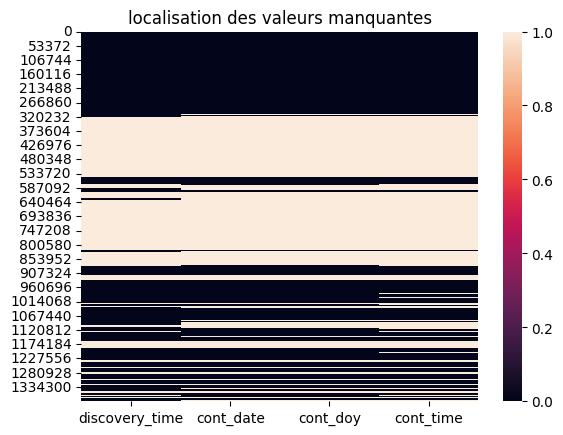

In [ ]:
# localisation des NaN
sns.heatmap(fires.loc[:,['discovery_time','cont_date','cont_doy','cont_time']].isna());
plt.title('localisation des valeurs manquantes');

## discovery_time

In [ ]:
# Utilité de Discovery_time
# nb nan discovery_time
print('nombre de NaN de la variable discovery_time : ',fires['discovery_time'].isna().sum())

nombre de NaN de la variable discovery_time :  611412


In [ ]:
# verification de la presence d'un horaire de decouverte n'ayant pas un code à 4 chiffres
for each in fires.dropna(subset=['discovery_time']).discovery_time:
  if len(each)!=4:
    print(each)

In [ ]:
# retrait des NaN
fires_discov = fires.dropna(subset=['discovery_time'])
print('taille initiale du dataframe : ',fires.shape[0],'\ntaille du dataframe après retrait des NaN : ',fires_discov.shape[0])

taille initiale du dataframe :  1387656 
taille du dataframe après retrait des NaN :  776244


In [ ]:
# recuperation uniquement de l'heure
fires_discov['discov_hr'] = (fires_discov.discovery_time.astype('str').str[0:2]).astype('int')

<ipython-input-43-a802d5e998e0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# graphique nombre d'incendie par cause par heure
# Groupement par heures et causes
fires_cause_hr = fires_discov.groupby(['discov_hr','stat_cause_descr']).agg(nb_feu =('stat_cause_descr', 'count')).reset_index()

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires_cause_hr.stat_cause_descr.unique():
  fig.add_traces(go.Scatter(x = fires_cause_hr[fires_cause_hr.stat_cause_descr==each].discov_hr,
                          y = fires_cause_hr[fires_cause_hr.stat_cause_descr==each].nb_feu, name=each))

# ajout des légendes
fig.update_layout(title = 'Evolution par heure par cause',  xaxis_title = 'Heure de découverte',  yaxis_title = 'Nombre')

# affichage
fig.show()

## cont_date, cont_doy et cont_time

In [ ]:
# valeurs manquantes sur le jeu de données total
fires.isna().sum()

fire_year                0
discovery_date           0
discovery_doy            0
discovery_time      611412
stat_cause_code          0
stat_cause_descr         0
cont_date           634458
cont_doy            634458
cont_time           676715
fire_size                0
fire_size_class          0
latitude                 0
longitude                0
state                    0
dtype: int64

In [ ]:
# sur fires :
# si discovery_date = cont_date alors regarder discovery_time et cont_time
# si discovery_date != cont_date alors regarder les 2 date

# nb nan
print('nombre enregistrement : ', len(fires))
print('nombre de NaN : ',len(fires) - len(fires.dropna(subset=['discovery_time','cont_date', 'cont_time'])))

nombre enregistrement :  1387656
nombre de NaN :  678950


In [ ]:
# retrait des NaN
fires_duree = fires.dropna(subset=['discovery_time','cont_date', 'cont_time']).reset_index(drop=True)
print('taille initiale du dataframe : ',fires.shape[0],'\ntaille du dataframe après retrait des NaN : ',fires_duree.shape[0])

taille initiale du dataframe :  1387656 
taille du dataframe après retrait des NaN :  708706


In [ ]:
# verification de la presence d'un horaire de fin n'ayant pas un code à 4 chiffres
for each in fires_duree.cont_time:
  if len(each)!=4:
    print(each)

In [ ]:
# calcul de la duree de l'incendie en heure
# recuperation uniquement de l'heure de debut
fires_duree['discov_hr'] = (fires_duree.discovery_time.astype('str').str[0:2]).astype('int')

# recuperation uniquement de l'heure de fin
fires_duree['cont_hr'] = (fires_duree.cont_time.astype('str').str[0:2]).astype('int')

fires_duree.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state,discov_hr,cont_hr
0,2004,2004-05-12,133,0845,1,Lightning,2004-05-12,133.0,1530,0.10125,A,38.933056,-120.404444,CA,8,15
1,2004,2004-05-31,152,1921,5,Debris Burning,2004-05-31,152.0,2024,0.04050,A,38.984167,-120.735556,CA,19,20
2,2004,2004-06-28,180,1600,1,Lightning,2004-07-03,185.0,1400,0.04050,A,38.559167,-119.913333,CA,16,14
3,2004,2004-06-28,180,1600,1,Lightning,2004-07-03,185.0,1200,0.04050,A,38.559167,-119.933056,CA,16,12
4,2004,2004-06-30,182,1800,1,Lightning,2004-07-01,183.0,1600,0.04050,A,38.635278,-120.103611,CA,18,16


In [ ]:
# calcul de la duree
# si discovery_date = cont_date alors cont_hr - discov_hr
# sinon (cont_date - discovery_date)*24
fires_duree['duree'] = [(fires_duree.loc[i, 'cont_hr'] - fires_duree.loc[i, 'discov_hr']) if fires_duree.loc[i,'cont_date'] == fires_duree.loc[i,'discovery_date'] else ((fires_duree.loc[i, 'cont_date'] - fires_duree.loc[i,'discovery_date'])/ np.timedelta64(1, "D") * 24) for i in range(fires_duree.shape[0])]

# affichage
fires_duree.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state,discov_hr,cont_hr,duree
0,2004,2004-05-12,133,0845,1,Lightning,2004-05-12,133.0,1530,0.10125,A,38.933056,-120.404444,CA,8,15,7.0
1,2004,2004-05-31,152,1921,5,Debris Burning,2004-05-31,152.0,2024,0.04050,A,38.984167,-120.735556,CA,19,20,1.0
2,2004,2004-06-28,180,1600,1,Lightning,2004-07-03,185.0,1400,0.04050,A,38.559167,-119.913333,CA,16,14,120.0
3,2004,2004-06-28,180,1600,1,Lightning,2004-07-03,185.0,1200,0.04050,A,38.559167,-119.933056,CA,16,12,120.0
4,2004,2004-06-30,182,1800,1,Lightning,2004-07-01,183.0,1600,0.04050,A,38.635278,-120.103611,CA,18,16,24.0


In [ ]:
# statistiques rapides
fires_duree.duree.describe()

count    708706.000000
mean         31.375809
std         294.284657
min           0.000000
25%           1.000000
50%           2.000000
75%           6.000000
max       87672.000000
Name: duree, dtype: float64

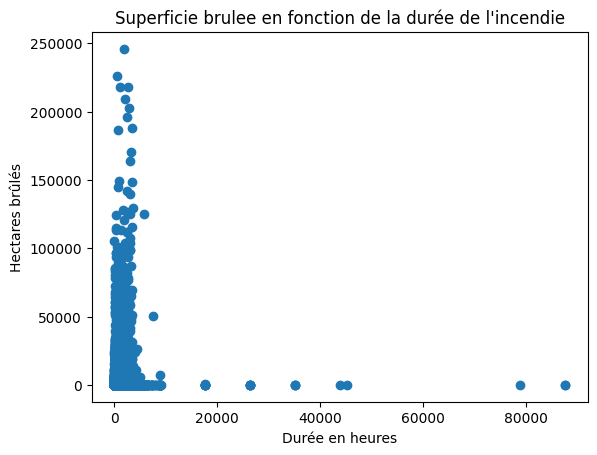

In [ ]:
# graphique durée vs taille incendie
plt.scatter(x='duree', y='fire_size', data=fires_duree);
plt.title('Superficie brulee en fonction de la durée de l\'incendie')
plt.xlabel('Durée en heures')
plt.ylabel('Hectares brûlés');
#plt.axis([1440,10000,-1,40000]);

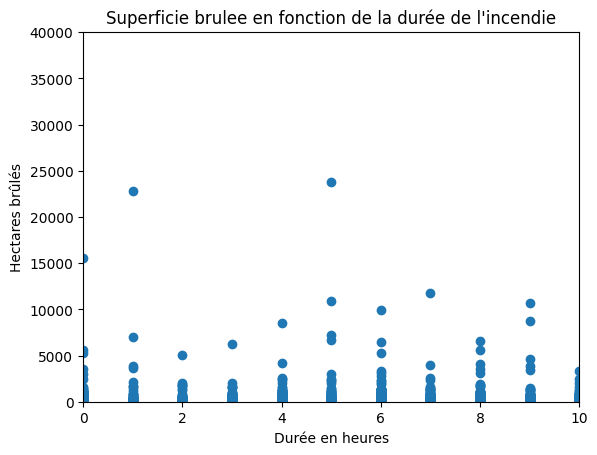

In [ ]:
# graphique durée vs taille incendie
plt.scatter(x='duree', y='fire_size', data=fires_duree);
plt.title('Superficie brulee en fonction de la durée de l\'incendie')
plt.xlabel('Durée en heures')
plt.ylabel('Hectares brûlés');
plt.axis([0,10,-1,40000]);

In [ ]:
# graphique cause vs duree
# Groupement par cause
fires_cause_med = fires_duree.groupby(['stat_cause_descr']).agg(duree =('fire_size', 'median')).reset_index()

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires_cause_med.stat_cause_descr.unique():
  fig.add_traces(go.Bar(x = fires_cause_med[fires_cause_med.stat_cause_descr==each].stat_cause_descr,
                          y = fires_cause_med[fires_cause_med.stat_cause_descr==each].duree, name=each))

# ajout des légendes
fig.update_layout(title = 'Durée médiane par cause',  xaxis_title = 'Cause',  yaxis_title = 'Duree (hr)')

# affichage
fig.show()

In [ ]:
# graphique nombre d'incendie par cause par etat
# Groupement par etat et cause
fires_cause_duree = fires_duree.groupby(['state','stat_cause_descr']).agg(duree =('duree', 'median')).reset_index()

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires_cause_duree.stat_cause_descr.unique():
  fig.add_traces(go.Bar(x = fires_cause_duree[fires_cause_duree.stat_cause_descr==each].state,
                          y = fires_cause_duree[fires_cause_duree.stat_cause_descr==each].duree, name=each))

# ajout des légendes
fig.update_layout(title = 'Durée médiane des incendies par cause et par état',  xaxis_title = 'Etat',  yaxis_title = 'Durée (hr)')

# affichage
fig.show()

## Saisonnalité : jour et mois

In [ ]:
# relation entre cause et jour calendaire
# Utilisation de discovery_date pour mettre le mois et le jour
fires_duree['jour'] = fires_duree.discovery_date.apply(lambda x : x.isoweekday()) # lundi = 1
fires_duree['mois'] = fires_duree.discovery_date.apply(lambda x : x.month)

# affichage
fires_duree.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,fire_size_class,latitude,longitude,state,discov_hr,cont_hr,duree,jour,mois
0,2004,2004-05-12,133,0845,1,Lightning,2004-05-12,133.0,1530,0.10125,A,38.933056,-120.404444,CA,8,15,7.0,3,5
1,2004,2004-05-31,152,1921,5,Debris Burning,2004-05-31,152.0,2024,0.04050,A,38.984167,-120.735556,CA,19,20,1.0,1,5
2,2004,2004-06-28,180,1600,1,Lightning,2004-07-03,185.0,1400,0.04050,A,38.559167,-119.913333,CA,16,14,120.0,1,6
3,2004,2004-06-28,180,1600,1,Lightning,2004-07-03,185.0,1200,0.04050,A,38.559167,-119.933056,CA,16,12,120.0,1,6
4,2004,2004-06-30,182,1800,1,Lightning,2004-07-01,183.0,1600,0.04050,A,38.635278,-120.103611,CA,18,16,24.0,3,6


In [ ]:
# relation entre le mois de l'incendie et la cause
fires_mois_cause = fires_duree.groupby(['mois','stat_cause_descr']).agg({'stat_cause_descr':'count'}).unstack()

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires_mois_cause.stat_cause_descr:
  fig.add_traces(go.Scatter(x = fires_mois_cause.index,
                          y = fires_mois_cause.loc[:,('stat_cause_descr', each)], name=each))

# ajout des légendes
fig.update_layout(title = 'Evolution du nombre d\'incendie par mois et par cause',  xaxis_title = 'Mois',  yaxis_title = 'Nombre')

fig.update_xaxes(
    ticktext=['Jan', 'Fev', 'Mars', 'Avril', 'Mai', 'Juin', 'Juil', 'Aou', 'Sept', 'Oct', 'Nov', 'Dec'],
    tickvals=[1,2,3,4,5,6,7,8,9,10,11,12]
)

# affichage
fig.show()

In [ ]:
# relation entre le jour semaine de l'incendie et la cause
fires_jour_cause = fires_duree.groupby(['jour','stat_cause_descr']).agg({'stat_cause_descr':'count'}).unstack()

# Creation de la figure
fig = go.Figure()

# ajout type graphique
for each in fires_jour_cause.stat_cause_descr:
  fig.add_traces(go.Scatter(x = fires_jour_cause.index,
                          y = fires_jour_cause.loc[:,('stat_cause_descr', each)], name=each))

# ajout des légendes
fig.update_layout(title = 'Evolution du nombre d\'incendie par jour et par cause',  xaxis_title = 'Jour',  yaxis_title = 'Nombre')

fig.update_xaxes(
    ticktext=['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'],
    tickvals=[1,2,3,4,5,6,7]
)

# affichage
fig.show()

# PRE-PROCESSING

In [ ]:
# départ du jeu de données après la première exploration
fires = fires_explo.copy()

## retrait des NaN pour les variables de temps discovery_time, cont_date, cont_time

In [ ]:
# retrait des NaN pour les variables de temps discovery_time, cont_date, cont_time
fires_model = fires.dropna(subset=['discovery_time','cont_date', 'cont_time']).reset_index(drop=True)

## ajout des variables

### *Heure découverte*

In [ ]:
# recuperation uniquement de l'heure de debut
fires_model['discov_hr'] = (fires_model.discovery_time.astype('str').str[0:2]).astype('int')

### *Duree*

In [ ]:
# recuperation uniquement de l'heure de fin
fires_model['cont_hr'] = (fires_model.cont_time.astype('str').str[0:2]).astype('int')

# calcul de la duree
# si discovery_date = cont_date alors cont_hr - discov_hr
# sinon (cont_date - discovery_date)*24
fires_model['duree'] = [(fires_model.loc[i, 'cont_hr'] - fires_model.loc[i, 'discov_hr']) if fires_model.loc[i,'cont_date'] == fires_model.loc[i,'discovery_date'] else ((fires_model.loc[i, 'cont_date'] - fires_model.loc[i,'discovery_date'])/ np.timedelta64(1, "D") * 24) for i in range(fires_model.shape[0])]


### *Jour et Mois*

In [ ]:
# variables jour de la semaine et mois
fires_model['jour'] = fires_model.discovery_date.apply(lambda x : x.isoweekday()) # lundi = 1
fires_model['mois'] = fires_model.discovery_date.apply(lambda x : x.month)


### *Etat en numérique*

In [ ]:
#code_usa=pd.DataFrame(etat, columns=['state'], index=np.arange(1,53)).reset_index()
code_usa = pd.DataFrame({'state_usa': fires_model.sort_values(by='state', ascending=True).state.unique(),
                        'state_code' : np.arange(1,53)})

In [ ]:
# jointure
fires_model = fires_model.merge(code_usa, how='left', left_on='state', right_on='state_usa')
fires_model = fires_model.drop(['state_usa'], axis=1)


### *Causes des incendies*

In [ ]:
# regroupement des classes incendies
# Regroupé en brulis #14
# Smoking #3
# Campfire #4
# Debris burning #5

# retrait causes
# Structure #12

# Debris
fires_model['stat_cause_code'] = fires_model.stat_cause_code.apply(lambda x: 14 if (x >2 and x<6) else x)

# retrait
fires_model = fires_model[fires_model.stat_cause_code != 12].reset_index(drop=True)
print(fires_model['stat_cause_code'].unique())
print('nombre de lignes pour la separation : ', fires_model.shape[0])

[ 1 14  2  7  8  6 11 10]
nombre de lignes pour la separation :  706112


## séparation du jeu de données

In [ ]:
                                                                       # separation des variables explicatives et cible
X = fires_model.drop(['discovery_date','stat_cause_descr','cont_date','state','fire_size_class','cont_doy','cont_time','stat_cause_code'], axis=1)
# affichage
display(X.info())

# stat_cause_code
y = fires_model.stat_cause_code

# separation des données en entrainement et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

# affichage
X_train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 706112 entries, 0 to 706111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fire_year       706112 non-null  int64  
 1   discovery_doy   706112 non-null  int64  
 2   discovery_time  706112 non-null  object 
 3   fire_size       706112 non-null  float64
 4   latitude        706112 non-null  float64
 5   longitude       706112 non-null  float64
 6   discov_hr       706112 non-null  int64  
 7   cont_hr         706112 non-null  int64  
 8   duree           706112 non-null  float64
 9   jour            706112 non-null  int64  
 10  mois            706112 non-null  int64  
 11  state_code      706112 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 64.6+ MB


None

(564889, 12)

## modifications

### Formats

In [ ]:
# modification type objet en entier
X_train['discovery_time'] = X_train['discovery_time'].astype('int')
X_test['discovery_time'] = X_test['discovery_time'].astype('int')

### Outliers

In [ ]:
# taille incendie
# plus grand incendie du siècle = 40 000 ha
size_max = 40000

# Jeu d'entrainement
if len(X_train[X_train.fire_size>size_max])>0:
  print('X_train, nombre incendie taille > {} : {}'.format(size_max,len(X_train[X_train.fire_size>size_max])))

  # decision : suppression des lignes
  X_train = X_train[X_train['fire_size'] <= size_max]

  # mise à jour variable cible
  y_train = y_train[X_train.index]

  # affichage
  print('nombre de lignes restantes : ', len(X_train), end='\n\n')

else :
  print('Pas de feux ayant une taille supérieure à la taille maximale de {} dans le jeu d\'entrainement.'.format(size_max), end='\n\n')
  print('nombre de lignes restantes : ', len(X_train))


# Jeu de test
if len(X_test[X_test.fire_size>size_max])>0:
  print('X_test, nombre incendie taille > {} : {}'.format(size_max,len(X_test[X_test.fire_size>size_max])))

  # decision : suppression des lignes
  X_test = X_test[X_test['fire_size'] <= size_max]

  # mise à jour variable cible
  y_test = y_test[X_test.index]

  # affichage
  print('nombre de lignes restantes : ', len(X_test), end='\n\n')

else :
  print('Pas de feux ayant une taille supérieure à la taille maximale de {} dans le jeu de test.'.format(size_max))
  print('nombre de lignes restantes : ', len(X_test))

X_train, nombre incendie taille > 40000 : 122
nombre de lignes restantes :  564767

X_test, nombre incendie taille > 40000 : 42
nombre de lignes restantes :  141181



In [ ]:
# duree
# nombre d'incendie d'une duree > 2000 soit 3 mois
duree_max = 2000

# jeu d'entrainement
if len(X_train[X_train.duree>duree_max])>0:
  print('X_train, nombre incendie duree > {} : {}'.format(duree_max,len(X_train[X_train.duree>duree_max])))

  # decision : suppression des lignes
  X_train = X_train[X_train['duree'] <= duree_max]

  # mise à jour variable cible
  y_train = y_train[X_train.index]

  # affichage
  print('nombre de lignes restantes : ', len(X_train), end='\n\n')

else :
  print('Pas de feux ayant une duree supérieure à la duree maximale de {} dans le jeu d\'entrainement.'.format(duree_max))
  print('nombre de lignes restantes : ', len(X_train))

# jeu de test
if len(X_test[X_test.duree>duree_max])>0:
  print('X_test, nombre incendie duree > {} : {}'.format(duree_max,len(X_test[X_test.duree>duree_max])))

  # decision : suppression des lignes
  X_test = X_test[X_test['duree'] <= duree_max]

  # mise à jour variable cible
  y_test = y_test[X_test.index]

  # affichage
  print('nombre de lignes restantes : ', len(X_test), end='\n\n')

else :
  print('Pas de feux ayant une duree supérieure à la duree maximale de {} dans le jeu de test.'.format(duree_max))
  print('nombre de lignes restantes : ', len(X_test))

X_train, nombre incendie duree > 2000 : 1242
nombre de lignes restantes :  563525

X_test, nombre incendie duree > 2000 : 330
nombre de lignes restantes :  140851



In [ ]:
# duree <=2 et taille >= 15000 ha
duree_min = 2
taille_min = 15000

# jeu d'entrainement
if len(X_train[(X_train.duree<=duree_min) & (X_train.fire_size>=taille_min)])>0:
  print('X_train, nombre incendie duree <= {} et taille >= {} : {}'.format(duree_min, taille_min, len(X_train[((X_train.duree<=duree_min) & (X_train.fire_size>=taille_min))])))

  # decision : suppression des lignes
  X_train = X_train[-((X_train.duree<=duree_min) & (X_train.fire_size>=taille_min))]

  # mise à jour variable cible
  y_train = y_train[X_train.index]

  # affichage
  print('nombre de lignes restantes : ', len(X_train), end='\n\n')

else :
  print('Pas de feux ayant une duree <= {} et une taille >= {} dans le jeu d\'entrainement.'.format(duree_min, taille_min))
  print('nombre de lignes restantes : ', len(X_train))

# jeu de test
if len(X_test[(X_test.duree<=duree_min) & (X_test.fire_size>=taille_min)])>0:
  print('X_test, nombre incendie duree <= {} et taille >= {} : {}'.format(duree_min, taille_min,len((X_test.duree<=duree_min) & (X_test.fire_size>taille_min))))

  # decision : suppression des lignes
  X_test = X_test[-((X_test.duree<=duree_min) & (X_test.fire_size>=taille_min))]

  # mise à jour variable cible
  y_test = y_test[X_test.index]

  # affichage
  print('nombre de lignes restantes : ', len(X_test), end='\n\n')

else :
  print('Pas de feux ayant une duree <= {} et une taille >= {} dans le jeu de test.'.format(duree_min, taille_min))
  print('nombre de lignes restantes : ', len(X_test))

X_train, nombre incendie duree <= 2 et taille >= 15000 : 2
nombre de lignes restantes :  563523

Pas de feux ayant une duree <= 2 et une taille >= 15000 dans le jeu de test.
nombre de lignes restantes :  140851


### Standardisation

In [ ]:
# standardisation
# vue les valeurs extrêmes, utilisation du robust scaling qui est basé sur la médiane

# instanciation
scaler = RobustScaler()

# normalisation
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [ ]:
# KNN

# Importer les bibliothèques nécessaires
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Instanciation du modèle
knn = KNeighborsClassifier(n_neighbors=5)

# Entraîner le modèle
knn.fit(X_train_norm, y_train)

# Prédire sur l'ensemble d'entraînement
y_train_pred = knn.predict(X_train_norm)

# Prédire sur l'ensemble de test
y_pred = knn.predict(X_test_norm)

# Évaluer le modèle sur l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Score d'entraînement (Accuracy): ", train_accuracy)

# Évaluer le modèle sur l'ensemble de test
test_accuracy = accuracy_score(y_test, y_pred)
print("Score de test (Accuracy): ", test_accuracy)

Score d'entraînement (Accuracy):  0.7087607781758686
Score de test (Accuracy):  0.5968434728897913


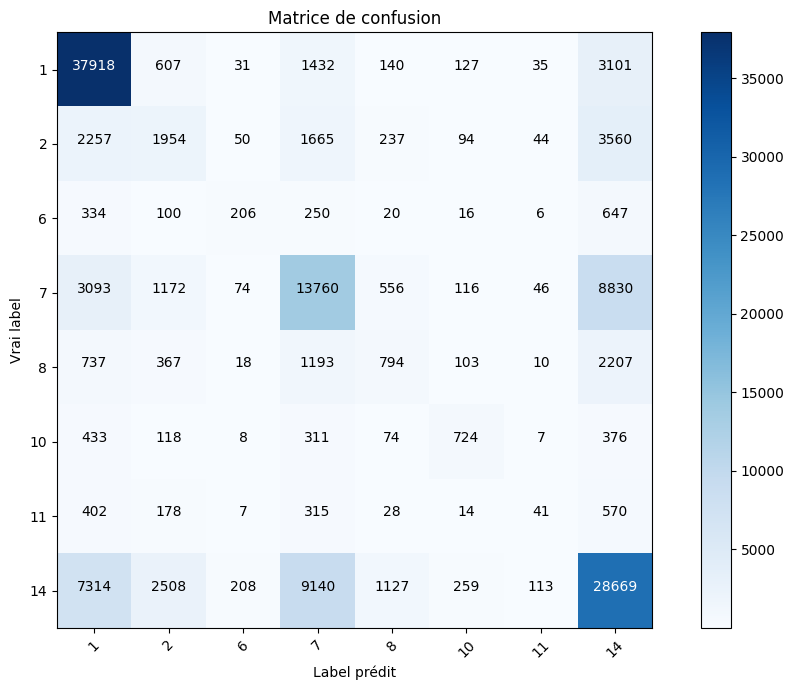

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()

labels = np.unique(y_test)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Afficher le nombre de prédictions dans chaque case de la matrice
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.ylabel('Vrai label')
plt.xlabel('Label prédit')
plt.tight_layout()
plt.show()

In [ ]:
#GridSearch

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# Liste des hyperparamètres à tester
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform'],
    'metric': ['euclidean'],
    'algorithm': ['auto']
}
knn = KNeighborsClassifier()

# Utilisation de GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_norm, y_train)
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
print("Meilleure précision obtenue avec ces paramètres : ", grid_search.best_score_)
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_norm)

from sklearn.metrics import accuracy_score, classification_report
print("Précision :", accuracy_score(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))
display(pd.crosstab(index = y_test, columns = y_pred, rownames = ['Classes réelles'], colnames = ['Classes prédites']))

Meilleurs paramètres trouvés :  {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Meilleure précision obtenue avec ces paramètres :  0.6119058135902069
Précision : 0.6126190087397321

Rapport de classification :
               precision    recall  f1-score   support

           1       0.73      0.88      0.80     43391
           2       0.32      0.17      0.22      9861
           6       0.43      0.10      0.16      1579
           7       0.51      0.50      0.50     27647
           8       0.33      0.12      0.18      5429
          10       0.52      0.36      0.43      2051
          11       0.23      0.02      0.03      1555
          14       0.59      0.63      0.61     49338

    accuracy                           0.61    140851
   macro avg       0.46      0.35      0.37    140851
weighted avg       0.58      0.61      0.59    140851



Classes prédites,1,2,6,7,8,10,11,14
Classes réelles,,,,,,,,
1,38223,448,19,1298,106,121,11,3165
2,2219,1650,32,1573,162,86,17,4122
6,338,77,157,228,18,15,3,743
7,2937,833,31,13782,330,120,13,9601
8,727,277,13,1120,671,110,2,2509
10,423,86,2,293,51,742,1,453
11,383,141,5,318,23,12,25,648
14,7160,1720,109,8359,703,214,35,31038


### RandomForest - Classique

In [ ]:
# instanciation
rf = RandomForestClassifier(random_state = 42)

# entrainement
rf.fit(X_train_norm, y_train)

# scores du modèle
print('Score sur ensemble train', rf.score(X_train_norm, y_train))
print('Score sur ensemble test', rf.score(X_test_norm, y_test))

Score sur ensemble train 0.9999804799449179
Score sur ensemble test 0.7014859674407707


In [ ]:
# Prédiction de la variable cible pour le jeu de données test
y_pred_rf = rf.predict(X_test_norm)

# affichage du rapport et de la matrice de confusion
print(classification_report(y_test, y_pred_rf))
display(pd.crosstab(index = y_test, columns = y_pred_rf, rownames = ['Classes réelles'], colnames = ['Classes prédites']))

              precision    recall  f1-score   support

           1       0.82      0.90      0.86     43391
           2       0.51      0.25      0.34      9861
           6       0.90      0.21      0.34      1579
           7       0.65      0.62      0.63     27647
           8       0.50      0.19      0.27      5429
          10       0.69      0.51      0.59      2051
          11       0.56      0.06      0.11      1555
          14       0.65      0.76      0.70     49338

    accuracy                           0.70    140851
   macro avg       0.66      0.44      0.48    140851
weighted avg       0.69      0.70      0.68    140851



Classes prédites,1,2,6,7,8,10,11,14
Classes réelles,,,,,,,,
1,39208,280,3,819,54,65,11,2951
2,1533,2504,5,1146,143,53,19,4458
6,254,54,333,147,6,5,2,778
7,1284,543,8,17125,286,83,16,8302
8,451,232,5,889,1029,98,1,2724
10,284,65,0,198,36,1044,0,424
11,294,173,1,237,20,11,93,726
14,4259,1014,16,5913,495,149,23,37469


# **STOP - En cours d'ajout**

### RandomForest - OverSampling

In [ ]:
# étape de sous-echantillonnage des classes majoritaires pour équilibrer les classes
# instance
ros = RandomOverSampler(sampling_strategy='not majority', random_state = 42)

# re-echantillonage
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Nouvelle répartition des classes de la variable cible
print('nouvelle distribution de la variable cible :')
print(y_train_res.value_counts(normalize = True), end='\n\n')

# taille du jeu d'entrainement
print('taille jeu entrainement re-echantillonne : ',X_train_res.shape)

# standardisation
# vue les valeurs extrêmes, utilisation du robust scaling qui est basé sur la médiane
# instanciation
scaler = RobustScaler()

# normalisation
X_train_res = scaler.fit_transform(X_train_res)
X_test_res = scaler.transform(X_test)

# nombre de lignes
print('nombre de lignes pour l\'entrainement {}, nombre de lignes pour le test {}.'.format(len(X_train_res), len(X_test_res)))

nouvelle distribution de la variable cible :
1     0.125
14    0.125
7     0.125
8     0.125
2     0.125
11    0.125
6     0.125
10    0.125
Name: stat_cause_code, dtype: float64

taille jeu entrainement re-echantillonne :  (1571816, 12)
nombre de lignes pour l'entrainement 1571816, nombre de lignes pour le test 140851.


In [ ]:
# instanciation
rf = RandomForestClassifier(random_state = 42)

# entrainement
rf.fit(X_train_res, y_train_res)

# scores du modèle
print('Score sur ensemble train', rf.score(X_train_res, y_train_res))
print('Score sur ensemble test', rf.score(X_test_res, y_test))

Score sur ensemble train 0.9999898206914805
Score sur ensemble test 0.6996613442574068


In [ ]:
# Prédiction de la variable cible pour le jeu de données test
y_pred_rf = rf.predict(X_test_res)

# affichage du rapport et de la matrice de confusion
print(classification_report(y_test, y_pred_rf))
display(pd.crosstab(index = y_test, columns = y_pred_rf, rownames = ['Classes réelles'], colnames = ['Classes prédites']))

              precision    recall  f1-score   support

           1       0.83      0.90      0.86     43391
           2       0.45      0.34      0.39      9861
           6       0.78      0.29      0.42      1579
           7       0.63      0.65      0.64     27647
           8       0.42      0.26      0.32      5429
          10       0.64      0.57      0.61      2051
          11       0.38      0.11      0.17      1555
          14       0.67      0.71      0.69     49338

    accuracy                           0.70    140851
   macro avg       0.60      0.48      0.51    140851
weighted avg       0.69      0.70      0.69    140851



Classes prédites,1,2,6,7,8,10,11,14
Classes réelles,,,,,,,,
1,39059,545,12,951,96,89,48,2591
2,1338,3370,22,1156,224,83,76,3592
6,228,90,461,165,14,14,2,605
7,1180,887,18,17884,536,135,55,6952
8,428,342,13,859,1422,104,9,2252
10,227,104,5,175,64,1174,3,299
11,266,225,3,228,31,14,175,613
14,4194,1932,57,6861,978,216,97,35003


## Modèles

### RandomForest - Optimisation

In [ ]:
# GridSearch :
# grille des paramètres optimaux à tester
param_grid = {'criterion': ['gini','entropy'], 'class_weight': ['balanced', 'balanced_subsample']}

# instanciation
rf = RandomForestClassifier(random_state=42)

# recherche des meilleurs paramètres sur le métrique Recall à optimiser
rf_gs = GridSearchCV(rf, param_grid, cv=5, verbose=2, scoring='accuracy')

# entrainement
rf_gs.fit(X_train_norm, y_train)

# affichage des meilleurs paramètres
print('les meilleurs parametres sont :' ,rf_gs.best_params_)

# affichage du score sur le jeu de test
print('le score sur le jeu de test est : ',rf_gs.score(X_test_norm, y_test))

### RandomForest - Optimise

In [ ]:
# instanciation
rf = RandomForestClassifier(random_state = 42)

# entrainement
rf.fit(X_train_norm, y_train_res)

# scores du modèle
print('Score sur ensemble train', rf.score(X_train_norm, y_train_res))
print('Score sur ensemble test', rf.score(X_test_norm, y_test))

In [ ]:
# Prédiction de la variable cible pour le jeu de données test
y_pred_rf = rf.predict(X_test_norm)

# affichage du rapport et de la matrice de confusion
print(classification_report(y_test, y_pred_rf))
display(pd.crosstab(index = y_test, columns = y_pred_rf, rownames = ['Classes réelles'], colnames = ['Classes prédites']))